In [2]:
import os

import umap
import umap.plot
import requests
import pandas as pd
import numpy as np
import datashader as ds
import datashader.utils as utils
import datashader.transfer_functions as tf
import matplotlib.pyplot as plt
from mnist.loader import MNIST

In [3]:
import cudf
import cuml

In [4]:
print("Fetching Fashion-Mnist")
print("=========================")
mndata = MNIST('../fashion-mnist/data/fashion') #added path extension for new file structure
train, train_labels = mndata.load_training()
test, test_labels = mndata.load_testing()
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.hstack([train_labels, test_labels])
classes = [
    'T-shirt/top',
    'Trouser', 
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']
print("Fashion-Mnist loaded")
print ("=========================")

Fetching Fashion-Mnist
Fashion-Mnist loaded


## Establishing Control embedding 
There are currently some bugs with the random seed not giving the same embedding which is problematic 

In [96]:
neighbors=15
dim=2
epochs=500
dist=.2
seed=42
print(seed)

42


In [98]:
%%time
reducer = cuml.UMAP(
    n_neighbors=neighbors,
    n_components=dim,
    n_epochs=epochs,
    min_dist=dist,
    random_state=seed, #fix found on following blogpost https://github.com/lmcinnes/umap/issues/27 ?
)
control_embedding_2d = reducer.fit_transform(data)

CPU times: user 2.83 s, sys: 99.8 ms, total: 2.93 s
Wall time: 2.92 s


In [99]:
%%time
reducer = cuml.UMAP(
    n_neighbors=neighbors,
    n_components=dim,
    n_epochs=epochs,
    min_dist=dist,
    random_state=seed #fix found on following blogpost https://github.com/lmcinnes/umap/issues/27 ?
)
control_embedding_2d2 = reducer.fit_transform(data)

CPU times: user 2.85 s, sys: 79.7 ms, total: 2.93 s
Wall time: 2.93 s


In [100]:
np.linalg.norm(control_embedding_2d)-np.linalg.norm(control_embedding_2d2)

82.36841

sad news: https://github.com/rapidsai/cuml/issues/2980

So the issue is based on the matrices returned from cuml.UMAP not something downstream with plotting

"The RAPIDS implementation lacks some features, though. For example, the random state cannot be set, and the distance metric is fixed (it is not stated in the documentation. I assume it is Euclidean.). But if you don’t need those features, RAPIDS can save you a lot of time." -2019 https://medium.com/the-artificial-impostor/umap-on-rapids-15x-speedup-f4eabfbdd978

However in a blog post this is claimed to be fixed in a past update-  https://github.com/rapidsai/cuml/issues/1026 2019

Text(0.5, 1.0, 'Fashion MNIST Embedded via UMAP')

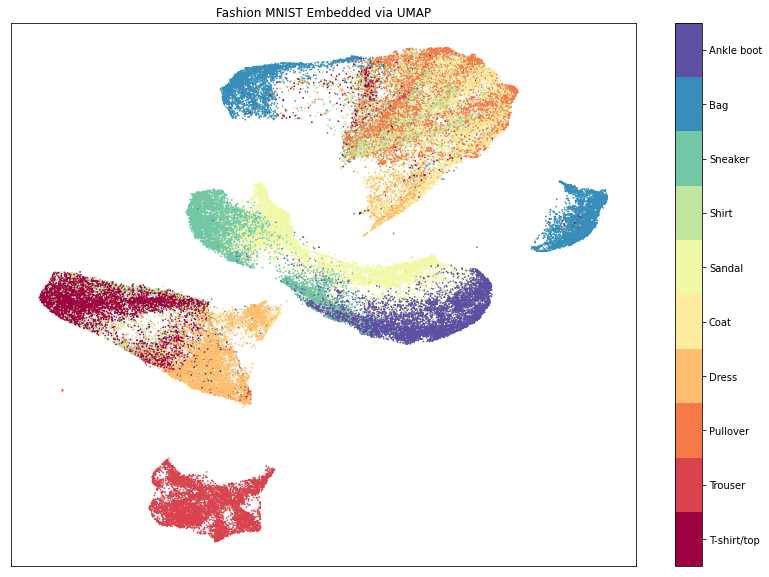

In [93]:
#Pd config
#-------------------------------------------------
df = pd.DataFrame(control_embedding_2d, columns=('x', 'y'))
df['class'] = pd.Series([str(x) for x in target], dtype="category")
#df_sample = df.sample(frac=0.25)
#Plot config
#-------------------------------------------------
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(df["y"].values,df["x"].values, c=df["class"].astype("int"), s=0.5, cmap='Spectral', alpha=1.0)

plt.setp(ax, xticks=[], yticks=[])

#Color Bar
#--------------------------------------------------
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
                        
#Title
#--------------------------------------------------
plt.title('Fashion MNIST Embedded via UMAP')

In [111]:
%%time
reducer = cuml.UMAP(
    n_neighbors=neighbors,
    n_components=dim,
    n_epochs=epochs,
    min_dist=dist,
    verbose=1,
    random_state=seed
)
control_embedding_2d = reducer.fit(data)

CPU times: user 2.85 s, sys: 79.8 ms, total: 2.93 s
Wall time: 2.93 s


In [1]:
gmapper = cuml.UMAP(n_neighbors=neighbors,
    n_components=dim,
    n_epochs=epochs,
    min_dist=dist,
    verbose=1,
    random_state=seed).fit(data)
umap.plot.points(gmapper) # plots the image

NameError: name 'cuml' is not defined

In [118]:
import cupy as cp
type(control_embedding_2d) #cuml.manifold.umap.UMAP

#control_embedding_2d.embedding_ = control_embedding_2d.embedding_.to_output('numpy')
##mapper2.metric = 'euclidean' # this is to avoid a warning, as of today, cuml does not support other metric
#control_embedding_2d=cupy.asnumpy(control_embedding_2d)
#type(control_embedding_2d)
c=control_embedding_2d.manifold.umap.umap_.UMAP
umap.plot.connectivity(c, show_points=True)

AttributeError: manifold